<a id='top'></a>

------


CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Section 7:  Saturday 20 October 10am EDT

*Dave Dowey*

--------


Topics for this section - Classification
================

- [K Nearest Neighbours](#knn)
    - simple example with the Spambase data
    - evaluation metrics
- [Decision Trees](#decision-trees)
    - simple Iris dataset example 
    - extended example with Car Seats dataset
- [Bias - Variance tradeoffs](#bias-variance)
- [Cross Validation](#cross-validation)
- [ROC curves](#ROC-curves)
- [Linear Discriminant Analysis](#Linear-Discriminant-Analysis)
- Q/A time
-------



In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import itertools

from sklearn import datasets
from sklearn.preprocessing import StandardScaler  
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import classification_report

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

##### The %run command loads some plotting code for the example figures below
# -five_fold_cv_calculation
# -plot_experimentation_strategies
# -plot_learning_curve
# The file is included in the zip file of the Section

%run plot_some_stuff.py

In [2]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
    

The next two cells are just formatting for Jupyter (centered, large fonts) and getting rid of scrolling boxes - no need to worry about them.

In [3]:
## Markdown CSS
from IPython.core.display import HTML
HTML("""
<style>

div.cell { 
    margin-top:1em;
    margin-bottom:1em;
}

div.text_cell_render h1 {
    font-size: 1.8em;
    line-height:1.2em;
    text-align:center;
}

div.text_cell_render h2 {
margin-bottom: -0.2em;
}

table tbody tr td:first-child, 
table tbody tr th:first-child, 
table thead tr th:first-child, 
table tbody tr td:nth-child(0), 
table thead tr th:nth-child(0) {
    background-color: #edf4e8;
}

div.text_cell_render { 
    font-family: 'Garamond';
    font-size:1.4em;
    line-height:1.3em;
    padding-left:3em;
    padding-right:3em;
}


div#notebook-container    { width: 95%; }
div#menubar-container     { width: 65%; }
div#maintoolbar-container { width: 99%; }

</style>
""")

<a id='knn'></a>

# K Nearest Neighbours
[Back to top](#top)


K Nearest Neighbours is:
- the simplest technique, and very intuitive to explain
- has lazy evaluation 
- only one hyper-parameter to tune $k$
- needs a distance measure to determine "nearest neighbour"

Drawbacks of K Nearest Neighbours include:
- suffers from the "Curse of Dimensionality"
- slow
- how to determine $k$ ?

### Once again, let's use the [spambase dataset](https://archive.ics.uci.edu/ml/datasets/Spambase)  


57 Attributes, 1 Target Variable - Spam Y or N 
4601 samples

### Dataset: Spambase

SPAM E-MAIL DATABASE ATTRIBUTES (in .names format)  


48 continuous real [0,100] attributes of type word_freq_WORD      
 = percentage of words in the e-mail that match WORD,     
 i.e. 100 * (number of times the WORD appears in the e-mail) /     
 total number of words in e-mail.  A "word" in this case is any       
 string of alphanumeric characters bounded by non-alphanumeric      
 characters or end-of-string.       


 6 continuous real [0,100] attributes of type char_freq_CHAR     
 = percentage of characters in the e-mail that match CHAR,     
 i.e. 100 * (number of CHAR occurences) / total characters in e-mail     
   
   
 1 continuous real [1,...] attribute of type capital_run_length_average       
 = average length of uninterrupted sequences of capital letters     
      
  
 1 continuous integer [1,...] attribute of type capital_run_length_longest    
 = length of longest uninterrupted sequence of capital letters      
    
 
 1 continuous integer [1,...] attribute of type capital_run_length_total    
 = sum of length of uninterrupted sequences of capital letters    
 = total number of capital letters in the e-mail   
   
    
 1 nominal {0,1} class attribute of type spam    
 = denotes whether the e-mail was considered spam (1) or not (0),     
 i.e. unsolicited commercial e-mail.     
   
   
 For more information, see file 'spambase.DOCUMENTATION' at the    
 UCI Machine Learning Repository: http://www.ics.uci.edu/~mlearn/MLRepository.html     



1, 0.    | spam, ham classes



In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
df = pd.read_csv(url,header=None)
df.columns = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d',
'word_freq_our','word_freq_over','word_freq_remove','word_freq_internet',     
'word_freq_order', 'word_freq_mail', 'word_freq_receive','word_freq_will',         
'word_freq_people', 'word_freq_report','word_freq_addresses','word_freq_free',         
'word_freq_business', 'word_freq_email','word_freq_you','word_freq_credit',      
'word_freq_your','word_freq_font',  'word_freq_000', 'word_freq_money',        
'word_freq_hp',  'word_freq_hpl',  'word_freq_george','word_freq_650',          
'word_freq_lab',   'word_freq_labs','word_freq_telnet','word_freq_857',          
'word_freq_data',  'word_freq_415', 'word_freq_85',    'word_freq_technology',
'word_freq_1999','word_freq_parts', 'word_freq_pm',  'word_freq_direct',     
'word_freq_cs',  'word_freq_meeting','word_freq_original','word_freq_project',      
'word_freq_re', 'word_freq_edu',     'word_freq_table',  'word_freq_conference', 
'char_freq_;', 'char_freq_(', 'char_freq_[',  'char_freq_!',            
'char_freq_$',  'char_freq_#','capital_run_length_average','capital_run_length_longest', 
'capital_run_length_total', 'Spam_YN']

print(df.shape)
df.head()

(4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Spam_YN
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
print(df.Spam_YN.value_counts()/df.shape[0])

X = df.iloc[:,0:57]
y = df.Spam_YN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=10) 
print (X.shape, X_train.shape, X_test.shape)
X.describe()

0    0.605955
1    0.394045
Name: Spam_YN, dtype: float64
(4601, 57) (2990, 57) (1611, 57)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


In [6]:
#Frequency count (%) for the Spam variable

100 * y.value_counts() / len(y)

0    60.595523
1    39.404477
Name: Spam_YN, dtype: float64

We should center and scale our data, since we will be using a distance measure. Note that we apply the scaling from the training set also to the test set data.


In [7]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

And then we use the SK Learn method. $k$ is set with the `n_neighbors` parameter.

In [8]:
knn_clf = KNeighborsClassifier(n_neighbors=5)  
knn_clf.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

This uses Euclidean distance as default (metric='minkowski', p=2) but you can try varying the $p$ parameter for different [distance metrics](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

In [9]:
# Predicting the classes
y_pred_knn = knn_clf.predict(X_test)

Great. We got a classifier. Now how well did it work? To assess that, we need some evaluation metrics.

## Evaluation Metrics

When there are unbalanced classes in a dataset, guessing the more common class will often yield very high accuracy. For this reason, we usually want to use different metrics that are less sensitive to imbalance when evaluating the predictive performance of classifiers. These metrics were originally developed for clinical trials, so to keep with the standard terminology, we define "spam" (value of 1) as "positive" and the "ham" (value of 0) as the "negative". We then define the following:

$P$ - number of positive examples in the sample.

$N$ - number of negative examples in the sample.

$TP$ - number of true positives: how many of the "positive" guesses of the classifier are true.

$FP$ - number of false positives: how many of the "positive" guesses of the classifier are actually negatives.

$TN$ - number of true negatives; similarly, this is how many of the "negative" guesses of the classifier are true.

$FN$ - number of false negatives; how many of the "negative" guesses are actually positives.

When calling the score functions in scikit-learn you obtained the default measure of efficiency, which is called **accuracy**. This is simply the ratio of successful guesses (both positives and negatives) across all samples:  

$$\text{accuracy} = \frac{TP + TN}{P+N}.$$  

In our case, when the two classes (spam and ham) are unbalanced in the sample, we should look for a better measure of efficiency. 

Usually, the goal is to identify the members of the positive class (the rare class) successfully -- this could be either the good wines or the patients presenting a rare disease. It is common practice to define the following ratios:



The **precision** is the ratio of the true positive guesses over all the positive guesses:   

$$\text{precision} = \frac{TP}{TP+FP}.$$  



The **recall** rate (also called the sensitivity or the true positive rate) is the ratio of true positive guesses among all positives:  

$$\text{recall} = \frac{TP}{P}=\frac{TP}{TP+FN}.$$  


### Recall and Precision Examples

Recall example: airport security screening, where you want a strategy that pulls aside all malicious passengers, even if it means that you also end up pulling aside many innocent people.

Precision example: when selecting job applicants for on-site interviews (which take a lot of time) you want to make sure that every selected applicant is good, and you don't care as much about interviewing every good applicant.

Actually, the [Wikipedia explanation of precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) is pretty good.

### F1 score

Because precision and recall both provide valuable information about the quality of a classifier, we often want to combine them into a single general-purpose score. The **F1** score is defined as the harmonic mean of recall and precision:
$$F_1 = \frac{2\times\text{recall}\times\text{precision}}{\text{recall} + \text{precision}}.$$

The harmonic mean of two numbers is closer to the smaller of the two numbers than the standard arithmetic mean. The **F1** score thus tends to favor classifiers that are strong in both precision and recall, rather than classifiers that emphasize one at the cost of the other.

To make these concepts clear, let's print them out for the Spambase example. First, the totals of positives (spam) and negatives (ham):

In [10]:
print("Actual class totals")
N = y_test.value_counts()[0]; print("Negatives:  ",N)
P = y_test.value_counts()[1]; print("Postives:  ",P)

Actual class totals
Negatives:   962
Postives:   649


And then, the counts of whether the predictions were true or false:

In [11]:
TP = np.sum(y_test*y_pred_knn); print("True Positives:  ",TP)
FP = np.sum((1-y_test)*(y_pred_knn)); print("False Positives:  ",FP)
TN = np.sum((1-y_test)*(1-y_pred_knn)); print("True Negatives:  ",TN)
FN = np.sum((y_test)*(1-y_pred_knn)); print("False Negatives:  ",FN)

True Positives:   564
False Positives:   62
True Negatives:   900
False Negatives:   85


And finally, the precision and recall measures:

In [12]:
TPR = TP/(TP+FP); print("Precision : {:.4} ".format(TPR))
recall = TP/(TP+FN); print("Recall (sensitivity or TPR): {:.4} ".format(recall))

Precision : 0.901 
Recall (sensitivity or TPR): 0.869 


In [13]:
targets =  ['ham', 'spam']

def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy score:  90.88% 

Classification report: 
             precision    recall  f1-score   support

        ham       0.91      0.94      0.92       962
       spam       0.90      0.87      0.88       649

avg / total       0.91      0.91      0.91      1611

Confusion_matrix: 
 [[900  62]
 [ 85 564]]


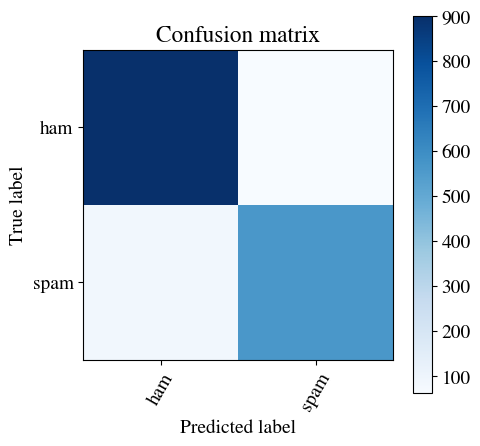

In [14]:
score = metrics.accuracy_score(y_test, y_pred_knn)
print ("Accuracy score:  {:.2%} \n".format(score))

print ("Classification report: ")
print(metrics.classification_report(y_test, y_pred_knn, target_names=targets))

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix, targets)

Looking at the confusion matrix, we can see some metrics that will be important for the ROC curve, a little later.

For ROC curves, **sensitivity** is just the recall from before, the ratio of true positive guesses among all positives:  
  
$$\text{sensitivity} = \text{tpr} = \text{recall} = \frac{TP}{P}=\frac{TP}{TP+FN}.$$  

And  **specificity** is the corresponding true negative rate,  the ratio of the true negative guesses over all the negatives:   

$$\text{specificity} = \text{fnr} = \frac{TN}{N}= \frac{TN}{TN+FP}.$$  


In [15]:
TNR = TN/(TN+FP); print("Specificity: {:.4} ".format(TNR))

Specificity: 0.9356 


And $1 - \text{specificity}$  is the false positive rate.

In [16]:
FPR = 1 - TNR; print("False positive rate (FPR): {:.4} ".format(FPR))
# FPR = FP/N ; print("False positive rate (FPR): {:.4} ".format(FPR))

False positive rate (FPR): 0.06445 


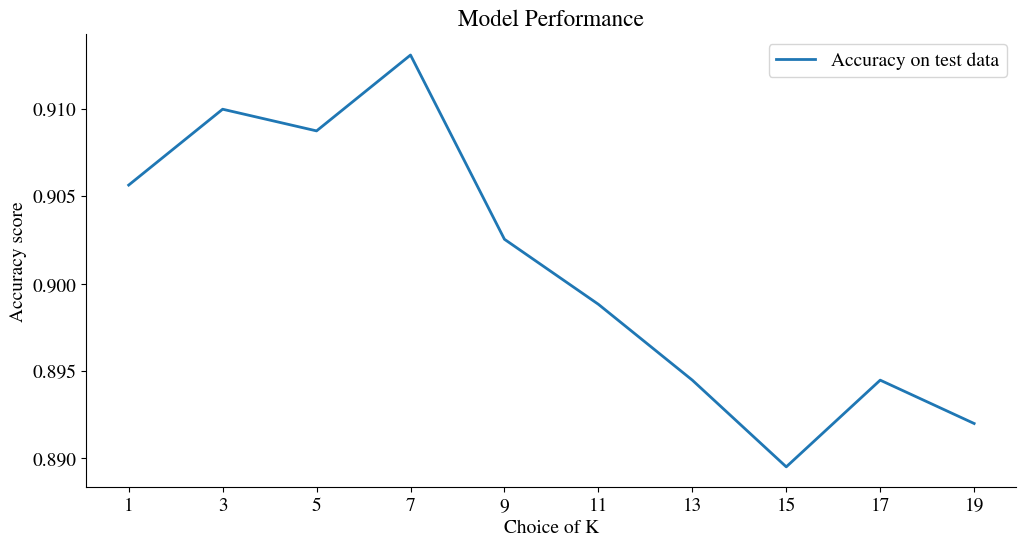

In [17]:
ds = range(1,20,2)
test_acc = np.zeros(len(ds))

for i, d in enumerate(ds):
    # create a model with training data 
    knn_clf = KNeighborsClassifier(n_neighbors=d).fit(X_train, y_train)
    # now score it on the test data set
    test_acc[i] = knn_clf.score(X_test, y_test)
    
plt.plot(ds, test_acc, lw=2, label = 'Accuracy on test data')
plt.legend(loc=0)
plt.xticks(ds)
plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Choice of K')
remove_border()
plt.show()

In [18]:
knn_clf = KNeighborsClassifier(n_neighbors=7)  
knn_clf.fit(X_train, y_train)  

# Predicting the classes
y_pred_knn = knn_clf.predict(X_test)

Accuracy score:  91.31% 

Classification report: 
             precision    recall  f1-score   support

        ham       0.92      0.94      0.93       962
       spam       0.91      0.87      0.89       649

avg / total       0.91      0.91      0.91      1611

Confusion_matrix: 
 [[905  57]
 [ 83 566]]


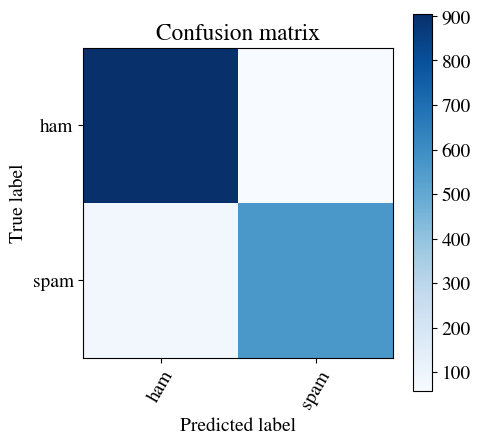

In [19]:
score = metrics.accuracy_score(y_test, y_pred_knn)
print ("Accuracy score:  {:.2%} \n".format(score))

print ("Classification report: ")
print(metrics.classification_report(y_test, y_pred_knn, target_names=targets))

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix, targets)

<a id='decision-trees'></a>

# Decision Trees
[Back to top](#top)


Decision tress are widely used classifiers because:
- They're simple to understand an interpret
- Require little data prep
- Processing cost is on the lower end of most classifiers (depends on size of dataset)
- Handles both numerical and categorical data (Can be used for regression or classification)

- Handles multi-output problems
- Non-parametric method
- Validation can be accomplished with [statistical tests](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score)

Drawbacks of Decision Trees though include:
- can overfit the data and create overly complex trees - there is a need to prune
- unstable from noisy (or complex) data
- works for continuous features, but categorization may throw away useful information

------

## Simple example


## Dataset: Iris species

Let's start with a simple example from the well known Iris classification problem.


![Iris measures](https://raw.githubusercontent.com/ritchieng/machine-learning-dataschool/master/images/03_iris.png)

In [20]:
# import the dataset using sklearn method
iris = datasets.load_iris()

print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [21]:
X = iris.data
y = iris.target
data = np.concatenate((X, y[..., np.newaxis]), axis=1)

# Assign colum names to the dataset
names = iris.feature_names + ['species']

# Read dataset to pandas dataframe
data = pd.DataFrame(data, columns=names) 
print()
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [22]:
# put test data aside
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120,)
(30,)


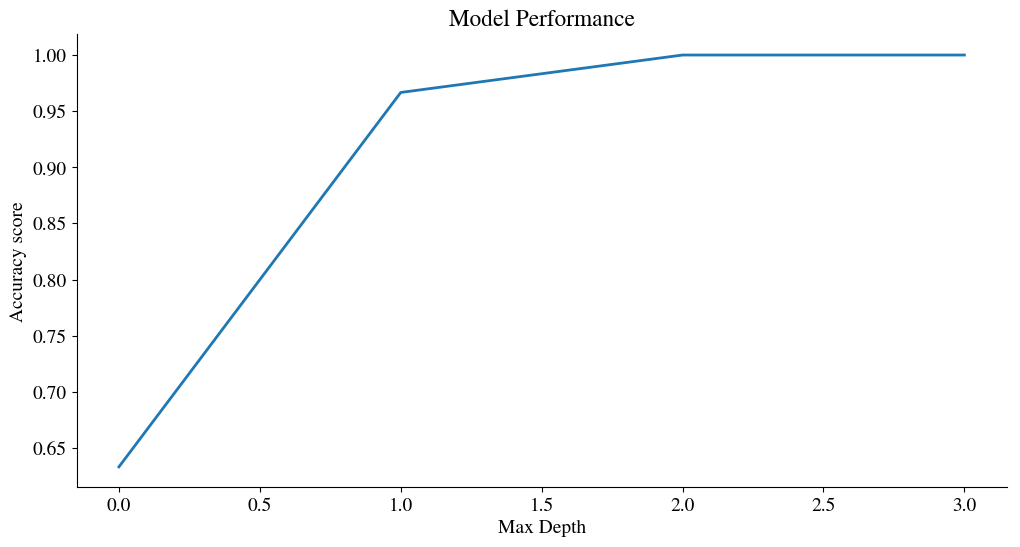

In [23]:
scores = []

for n in range(1,5):
    # create a model with training data 
    dt_clf = DecisionTreeClassifier(max_depth=n).fit(X_train, y_train)
    # now score it on the test data set
    scores.append(dt_clf.score(X_test, y_test))

plt.plot(scores)
plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Max Depth')
remove_border()
plt.show()

### Tree visualization

Requires the python library pydotplus and  [graphviz](http://www.graphviz.org)

In [24]:
import pydotplus
from sklearn.externals.six import StringIO 
from sklearn import tree

#pip install pydotplus
###### or...
# conda install -c conda-forge pydotplus=2.0.2
#brew install libtool 
###### or...
# conda install libtool
#brew install graphviz
#sudo chown -R $(whoami) /usr/local/lib/pkgconfig
#sudo chown -R $(whoami) usr/local/share/info

# for linking issues:
# brew unlink libtool && brew link libtool

In [25]:
#dt_clf = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

dot_data=StringIO()
tree.export_graphviz(dt_clf, out_file=dot_data, feature_names = names[:4])

In [26]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tree_iris.pdf")

True

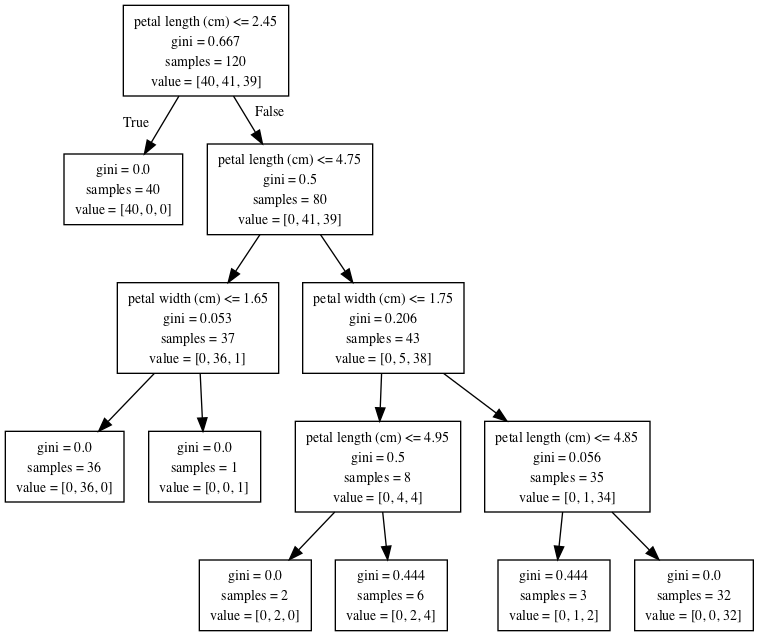

In [27]:
from IPython.display import Image #needed to render in notebook
Image(graph.create_png())

If you want a refresher on decision trees, then go through the slides in the [link on Canvas](https://www.slideshare.net/cnu/machine-learning-lecture-3/1) 

And here is another [decision tree tutorial](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/)
<img src="https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png">

If you don't set max_depth or similar parameters, then the tree will always keep splitting until every 
leaf is pure, and all the probabilities will be 1

### How to split nodes/leaves?

The slide deck shows the ID3 (Quinlan's algorithm) which uses entropy (information) gain, given the sample proportion $p_i$ in node $i$.  


$$ E(S) = \sum_{i=1}^c - p_i \cdot \log_2 p_i $$

So for a two-node split:

$$ E(S) =  - p \cdot \log_2 p - q \cdot \log_2 q  $$

We can also use a Gini coefficient.

### Gini Impurity


$$ G(S) = 1 - \sum_{i=1}^c  p_i^2  $$



from the [AnalyticsVidhya tutorial](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/)

Gini index says, if we select two items from a population at random then they must be of same class and probability for this is 1 if population is pure.

- It works with categorical target variable “Success” or “Failure”.
- It performs only Binary splits.
- Higher the value of Gini index higher the homogeneity - lower Gini impurity higher homogeneity
- CART (Classification and Regression Tree) uses Gini method to create binary splits.
  
  
   
   
1. Calculate Gini impurity for sub-nodes, using formula sum of square of probability for success and failure, e.g. $1 - p^2 - q^2$.
2. Calculate Gini impurity for split using weighted Gini impurity of each node of that split.
3. Pick the split with the lowest Gini impurity

### Decision Tree Surface

This example is borrowed from the sklearn documentation (http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html)

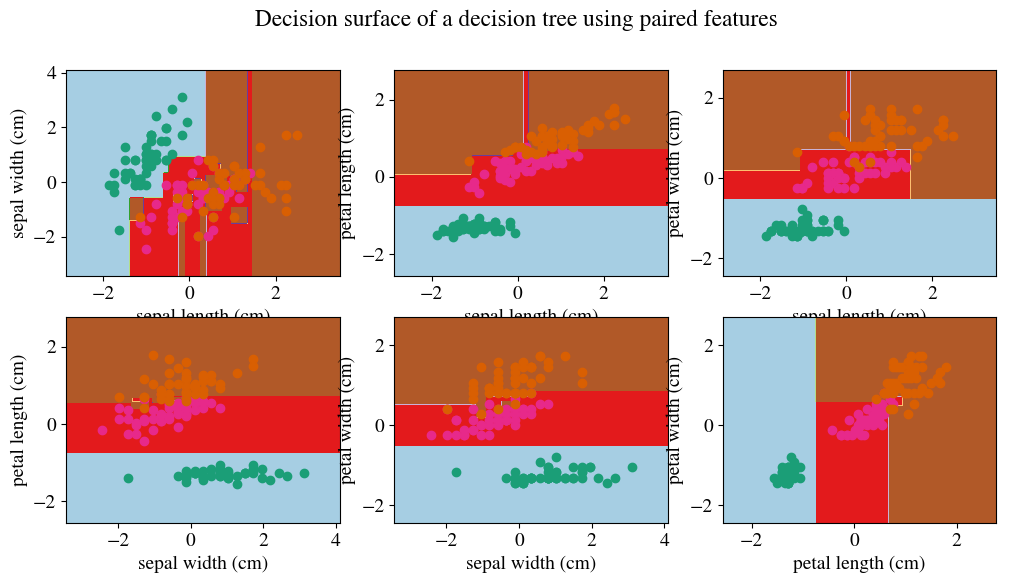

In [28]:
# Parameters
n_classes = 3
plot_colors = dark2_colors
plot_step = 0.02

# Load data
iris = datasets.load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

#     plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
# plt.legend()
plt.show()

------


## Extended example

## Dataset: Carseats - Sales of Child Car Seats

**Description** : A simulated data set containing sales of child car seats at 400 different stores.

**Format** : A data frame with 400 observations on the following 11 variables.

**Sales** : Unit sales (in thousands) at each location <br  />
**CompPrice** : Price charged by competitor at each location <br  />
**Income** : Community income level (in thousands of dollars) <br  />
**Advertising** : Local advertising budget for company at each location (in thousands of dollars) <br  />
**Population** : Population size in region (in thousands) <br  />
**Price** : Price company charges for car seats at each site <br  />
**ShelveLoc** : A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site <br  />
**Age** : Average age of the local population <br  />
**Education** : Education level at each location <br  />
**Urban** : A factor with levels No and Yes to indicate whether the store is in an urban or rural location <br  />
**US** : A factor with levels No and Yes to indicate whether the store is in the US or not <br  />

Source: Package ISLR in R

In [29]:
url = "https://s3.amazonaws.com/csci-e82-section-data/carseats.csv"
carseats = pd.read_csv(url,header=0)
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [30]:
#We will use this dataset to classify Sales as High or Low. We need to convert continuous Sales variable 
#to Categorical.
carseats.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


From the [Pandas documentation](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html)

##### Bin values into discrete intervals.     
##### Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins. 

In [31]:
#bins = [-1,5.39,9.32,17]
#group_names = ['Low', 'Medium', 'High']
bins = [-1,7.49,17]
group_names = ['Low',  'High']
carseats['Sales'] = pd.cut(carseats['Sales'], bins, labels=group_names)
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,High,138,73,11,276,120,Bad,42,17,Yes,Yes
1,High,111,48,16,260,83,Good,65,10,Yes,Yes
2,High,113,35,10,269,80,Medium,59,12,Yes,Yes
3,Low,117,100,4,466,97,Medium,55,14,Yes,Yes
4,Low,141,64,3,340,128,Bad,38,13,Yes,No


In [32]:
#Frequency count (%) for the Sales variable
#carseats.Sales.
100 * carseats.Sales.value_counts() / len(carseats.Sales)

Low     50.25
High    49.75
Name: Sales, dtype: float64

In [33]:
y = carseats['Sales'].map({'Low': 0, 'High': 1 })
carseats.drop('Sales',axis=1, inplace=True)

Next, we need to map the labels into categorical values.

In [34]:
pd.options.mode.chained_assignment = None
carseats['ShelveLoc'] = carseats['ShelveLoc'].map({'Bad': 0, 'Medium': 1, 'Good':2})
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes': 1 })
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1 })
pd.options.mode.chained_assignment = 'warn'

In [35]:
#Cross validation
#Split into training and validation set
X_train, X_test, y_train, y_test = train_test_split(carseats, y, test_size=.15, random_state=10) 
print (carseats.shape, X_train.shape, X_test.shape)

(400, 10) (340, 10) (60, 10)


### Questions
* Why choose test size that way?
* What is the effect of random_state?
* Do we hold out data for validation?

In [36]:
X_train.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
61,105,32,0,358,107,1,26,13,0,0
210,125,41,2,357,123,0,47,14,0,1
330,122,59,0,501,112,0,32,14,0,0
222,136,119,6,178,145,1,35,13,1,1
247,123,114,0,298,151,0,34,16,1,0


In [37]:
#Decision Tree Classifier - note: import statement at the top of Notebook!
# You can try changing: criterion='entropy'
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=37, max_depth=5)
dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

#print (y_pred_dt == y_test)
print()

DT_predprobability = dt_clf.predict_proba(X_test)
print (metrics.accuracy_score(y_test, y_pred_dt))


0.7666666666666667


[[28  8]
 [ 6 18]]


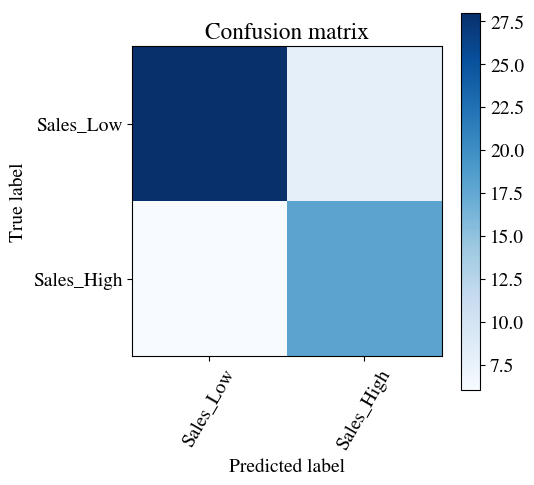

In [38]:
targets = ["Sales_Low", "Sales_High"]
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dt)
print (confusion_matrix)
show_confusion_matrix(confusion_matrix, targets)
#y_test = True Labels = 36 Sales Low, 24 Sales High
#y_pred_dt = Predicted Labels = 37 Sales Low, 23 Sales High

In [39]:
importance = pd.DataFrame({'feature': carseats.columns, 'importance': dt_clf.feature_importances_})
importance.sort_values(['importance', 'feature'], ascending=[0, 1], inplace=True)

From SKLearn, feature\_importances\_:  
*Return the feature importances. *  
*The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. *   

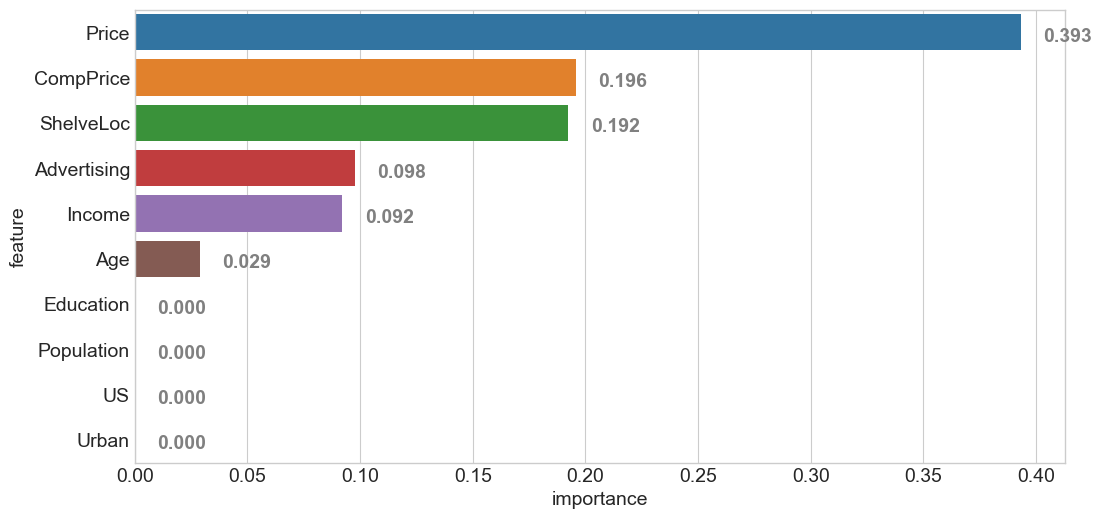

In [40]:
sns.set_style("whitegrid")
ax = sns.barplot(x="importance", y="feature", data=importance)
for i, v in enumerate(importance.importance):
    ax.text(v + .01, i +.20, '%1.3f'%v, color='gray', fontweight='bold')
plt.show()

In [41]:
dot_data=StringIO()
tree.export_graphviz(dt_clf, out_file=dot_data, feature_names = carseats.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tree_carseats.pdf")

True

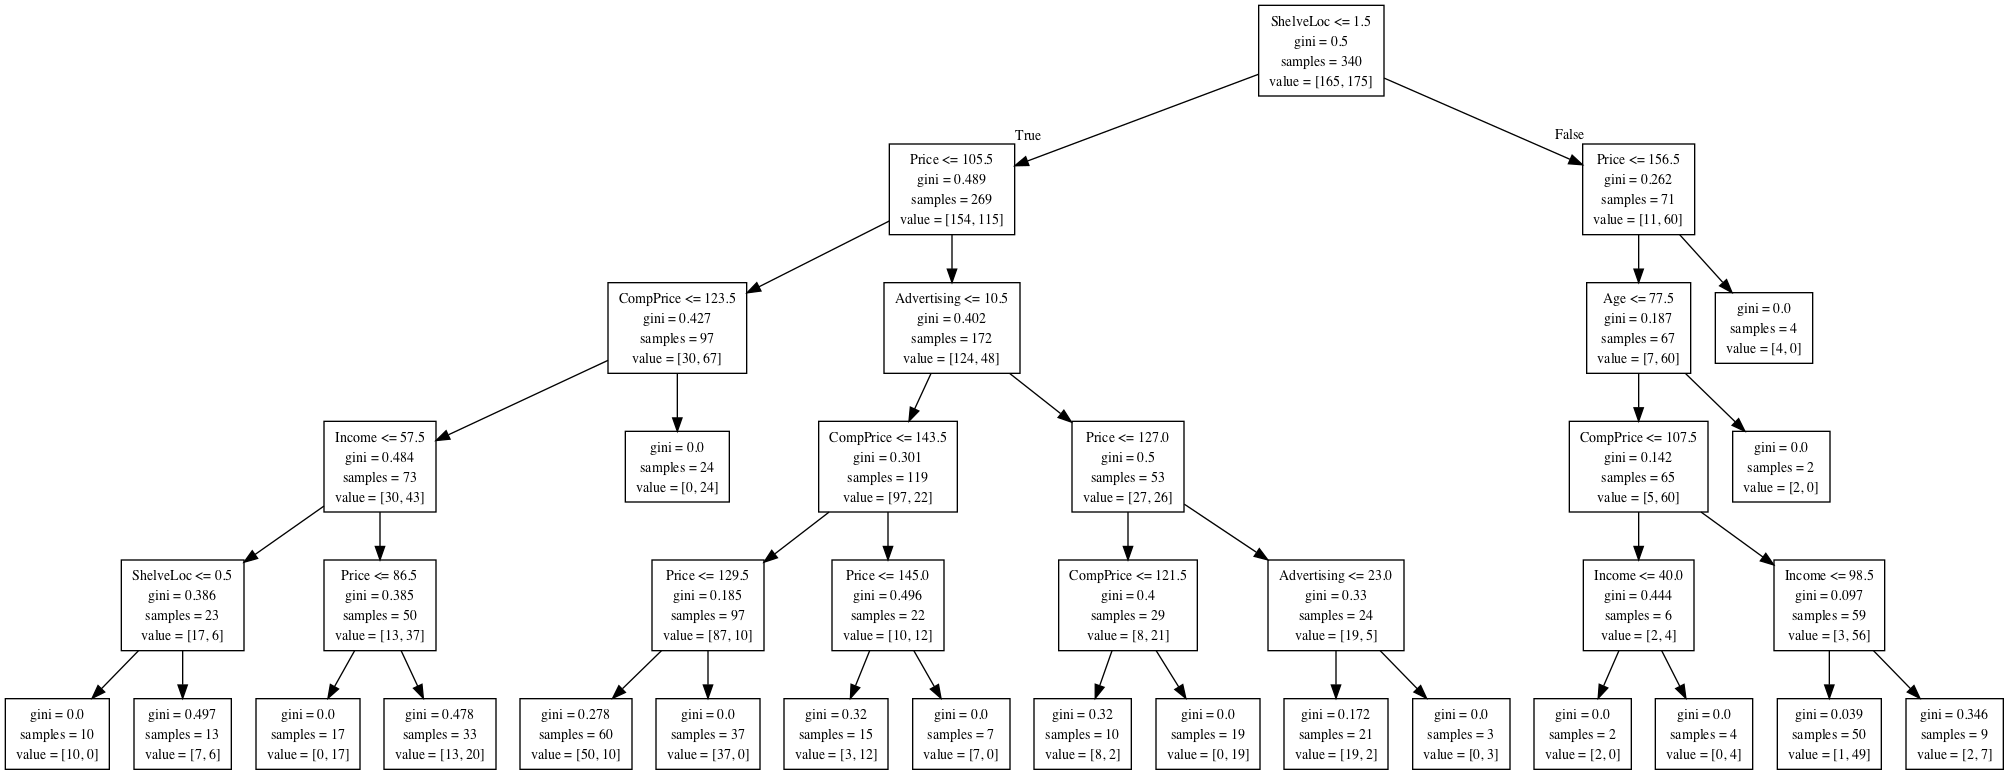

In [42]:
from IPython.display import Image #needed to render in notebook
Image(graph.create_png())

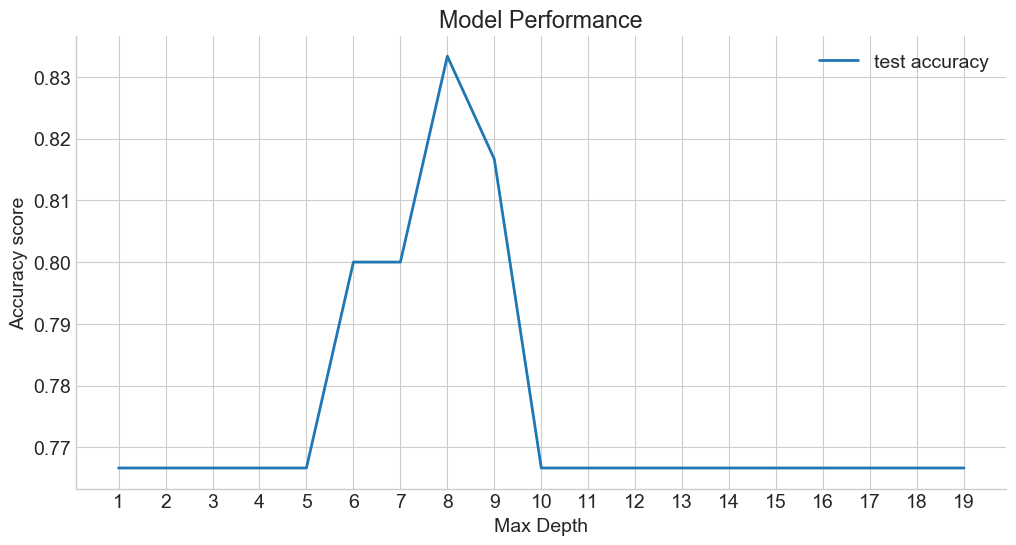

In [43]:
ds = range(1,20)
test_acc = np.zeros(len(ds))

for i, d in enumerate(ds):
    # create a model with training data 
    clf = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=37).fit(X_train, y_train)
    # now score it on the test data set
    test_acc[i] = clf.score(X_test, y_test)
    
plt.plot(ds, test_acc, lw=2, label = 'test accuracy')
plt.legend(loc=0)
plt.xticks(ds)
remove_border()
plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Max Depth')

plt.show()

## How can we know if our classifier performs well?
- How do we categorize and measure performance?
- What are the controllable and non-controllable factors?  
model and algorithm  
coding of the input  
number of features  
*hyperparameters of the classifier* including regularization parameters  
noise in the data  
resampling methods: randomness  
initial state for gradient descent  
- Minimize prediction error: RMSE, 0/1 Loss functions, log-likelihood
- Complexity - model complexity, but also time and space complexity

### "No free lunch" theorem  (at least until deep learning)
There is no "best" classifier or model. A classifier that performs well on some data, may perform poorly on other data.

<a id='bias-variance'></a>

------


[Back to top](#top)
# Bias - Variance 



We want to choose a model according to an arbitrage between bias and variance. Too "rough" will have low variance, but will be too general and with a pronounced bias. Too "articulate" will lead to over-fitting and a model that will be useless for prediction - it will not generalise well

We need to be able to train the model or classifier and then use some subset of the data to assess the possible choice of the *controllable* factors in the model.


<table>
<tr>
    <th> <img src="BiasVariance.png" alt="Bias-Variance" style="width: 400px;"/> </th>
    <th> <img src="Complexity.png" alt="Complexity" style="width: 600px;"/> </th>
</tr>
</table>

(left - from this [essay by Scott Fortmann-Roe](http://scott.fortmann-roe.com/docs/BiasVariance.html) )  
(right - from *Hastie et al*, Elements of Statistical Learning (2008))

### Back to regression:  
How does the degree of polynomial fit affect the bias-variance. Example from [here](https://github.com/jakevdp/sklearn_pycon2013/blob/master/notebooks/09_validation_and_testing.ipynb)

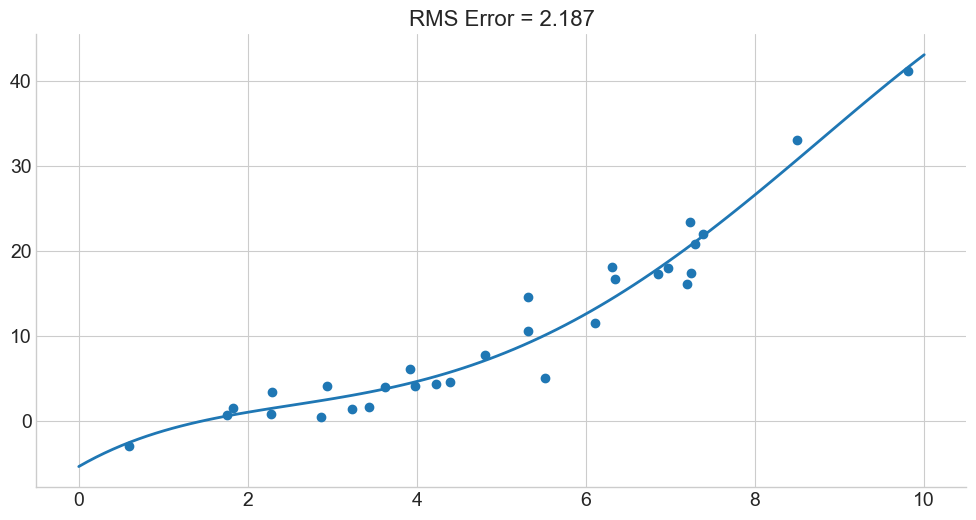

In [44]:
np.random.seed(123)
x = 10 * np.random.random(30)
y = 0.5 * x ** 2 - x + 1  + np.random.normal(0, 2, x.shape)

###############
degreeOFFit = 4
###############
p = np.polyfit(x, y, deg=degreeOFFit)
x_new = np.linspace(0, 10, 100)
y_new = np.polyval(p, x_new)

plt.scatter(x, y)
plt.plot(x_new, y_new)
plt.title("RMS Error = %.4g" % np.sqrt(np.mean((y - np.polyval(p, x)) ** 2)), fontsize=16)
remove_border()
_ = plt.show

## Validation

### Choices
* choice of factor design - how many hyperparameters?
* choice of how to split available data into training, validation and test sets (how much data are there?)
* randomization, replicability, blocking/pairing of data  

### Remember: 
* Training data: train classifier  
* Validation data: estimate (hyper) parameters (k)   
* Test data: measure performance   

### Validation method:
* Stratify randomly and designate one part a validation set (e.g. 1/3, 1/5 etc. of original "training" data)
* k-fold Cross-Validation
* 5x2 Cross-Validation (Dietterich 1998)
* Leave-one-out Cross-Validation
* Bootstrapping

It is important to note that the test set should only be used once for evaluating the prediction error of a classifier after training it on the training dataset; repetitive evaluations of different models using the same test dataset would be prone to overfitting.
A common approach to compare and evaluate different pre-processing techniques and models is cross-validation. Here, we will use a variant called "k-fold cross-validation" in order to compare different preprocessing steps and demonstrate the usefulness of a Pipeline.

In k-fold cross-validation, the original training dataset is split into k different subsets (the so-called "folds") where 1 fold is retained for testing the classifier and the other k-1 folds are used for training.  


<a id='cross-validation'></a>

--------

[Back to top](#top)


# Cross-validation

We can use cross validation to estimate the optimal value for $d$ (a tuning parameter of the classification - here the max depth). In the extended example, we'll use ***k fold cross validation*** to estimate the optimal value for $d$ for the car seat data. The original training dataset (not the test data) is split into k different folds, and at each iteration, one of the fold is designated the validation set and the $k-1$ others are used to train the classifier. Then the performance measure (i.e. a score: RMSE, accuracy, AUC) is calculated for that iteration. This is repeated for $k$ iterations, at each one a different fold is designated for validations. At the end, the $k$ performance scores are averaged to yield a CV score.

**Note**: In addition to the [test-train split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function seen above, Scikit learn includes [k-fold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) folding iterator, a method to perform a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), a function to [shuffle and split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) into training and validation sets and yet another [cross-val score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function that includes both k-fold technique and grid-search as options. These methods can also be implemented as part of [SK Learn's ML pipelines](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In your own time, have a look at [this nice demonstration](http://nbviewer.jupyter.org/github/cs109/content/blob/master/lec_10_cross_val.ipynb) on Cross-Validation the right and wrong way from Chris Beaumont for Harvard CS109 (2013 edition).

### Iteration over the k-folds. 
1. Determine the set(s) of hyperparameter values to choose from. (A word on this in a minute)  
2. For each hyperparameter value in the classifier/model:  
a. Fix the hyperparameter value.  
b. For each validation fold:  
Train the classifier with training data  
Validate against the validation data   
Calculate and save the performance result (accuracy, AUC, etc.)  
Repeat
2. For each hyperparameter, average the performance results across validation datasets  
3. Choose "optimal" hyperparameter values - interpolate and repeat 
4. DO NOT USE the test data to determine the parameters    

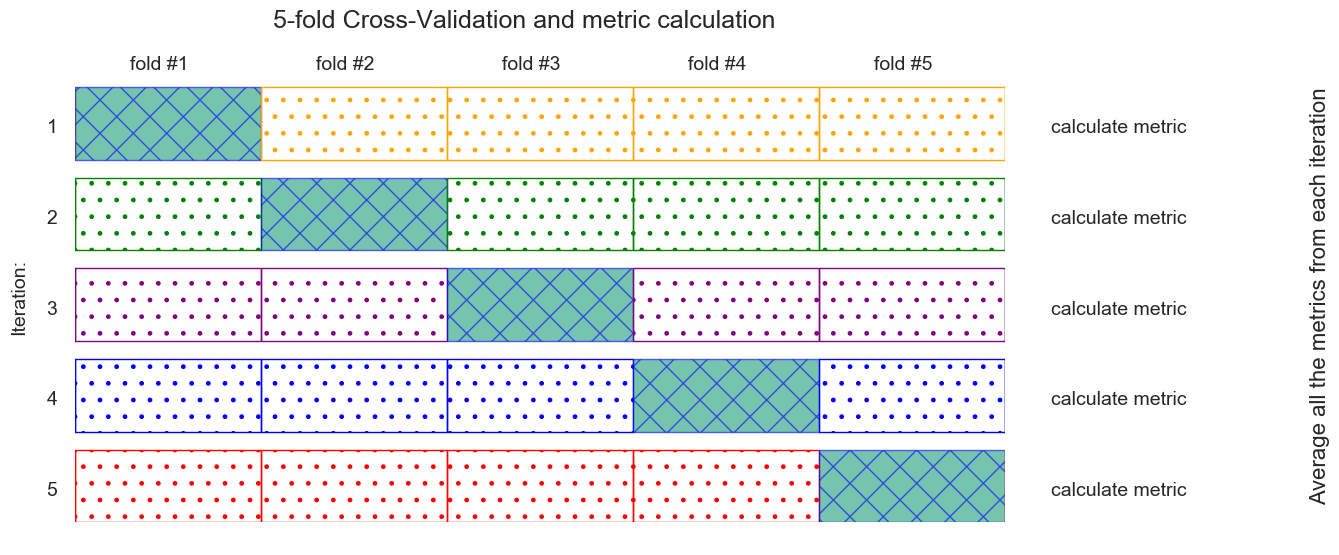

In [45]:
five_fold_cv_calculation()

IMPORTANT: do not use the test data to determine the parameters. It should only be used at the very end (once) to evaluate the prediction error of a classifier after training and validation. Otherwise, the classifier will overfit and lead to an over-optimistic assessment of performance.

/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


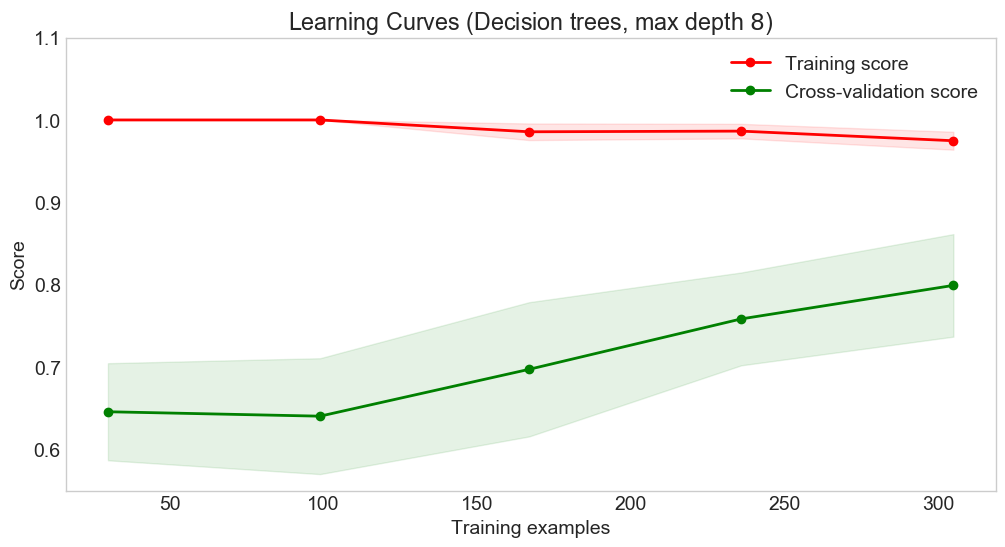

In [46]:
from sklearn.learning_curve import learning_curve

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=37)
title = "Learning Curves (Decision trees, max depth $8$)"
plot_learning_curve(dt_clf, title, X_train, y_train, ylim=(0.55,1.1), cv=10)
plt.show()

### SK Learn's K-fold method
* yields the indices of the various datasets
* number of elements: take all of the training dataset
* n_folds: the number of folds. 10 or 5 are typical choices (why?)
* shuffle: should the data be shuffled before splitting?
* random_state

In [47]:
from sklearn.cross_validation import KFold
kf_total = KFold(len(X_train), n_folds=10, shuffle=False, random_state=37)

# print out the indices for each fold, using a list comprehension
_ = [print ((len(train_indices), len(test_indices)) ) for train_indices, test_indices in kf_total]

(306, 34)
(306, 34)
(306, 34)
(306, 34)
(306, 34)
(306, 34)
(306, 34)
(306, 34)
(306, 34)
(306, 34)


In [48]:
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=37)

# print out the classification score for each fold, using a list comprehension
res = [dt_clf.fit(X_train.iloc[train_indices], y_train.iloc[train_indices]).score(X_train.iloc[test_indices],y_train.iloc[test_indices])
for train_indices, test_indices in kf_total]

print(res)
# now average them to get the CV score
print("\nAverage of the score results:", np.mean(res))

[0.8823529411764706, 0.7647058823529411, 0.6176470588235294, 0.7647058823529411, 0.7352941176470589, 0.8823529411764706, 0.8235294117647058, 0.7352941176470589, 0.6470588235294118, 0.8823529411764706]

Average of the score results: 0.773529411764706


Let's put this to practice on various choices for the `max_depth` parameter.

In [49]:
depths = list(range(1,20))
scores = np.zeros(len(depths))

for i, d in enumerate(depths):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=37)
    res = [clf.fit(X_train.iloc[train_indices], y_train.iloc[train_indices]).score(X_train.iloc[test_indices],y_train.iloc[test_indices])
            for train_indices, test_indices in kf_total]
    scores[i] = np.mean(res)

print (scores)

[0.60588235 0.7        0.71470588 0.73529412 0.77352941 0.78529412
 0.78823529 0.77941176 0.77058824 0.77352941 0.77941176 0.77941176
 0.77941176 0.77941176 0.77941176 0.77941176 0.77941176 0.77941176
 0.77941176]


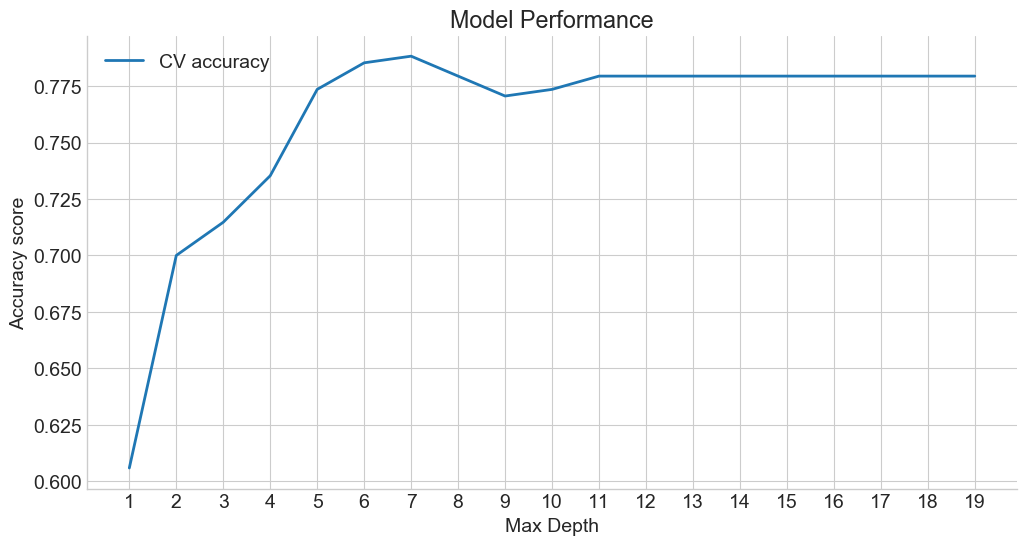

In [50]:
plt.plot(depths, scores, lw=2, label = 'CV accuracy')
plt.legend(loc=0)
plt.xticks(depths)
plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Max Depth')
remove_border()
plt.show()

### Experimentation over parameter space

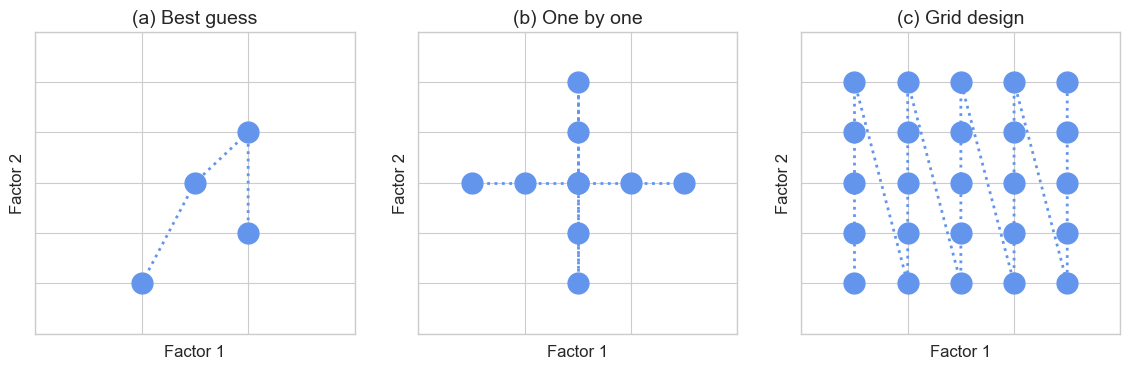

In [51]:
plot_experimentation_strategies()

### SK Learn's Grid-search method
* It automates what we have just done - you can choose the type of Cross-Validation
* feed it a dict of hyperparameter values - you can search over several hyperparameters
* Estimator: the SK Learn classifier
* param_grid: a dict or list of dictionaries with the hyperparameter grid
* cv: default 3-fold, or number of folds, or CV generator (a train/test split iterator)
* scoring: a string indicating the scorer - e.g 'accuracy'

In [52]:
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()

In [53]:
from sklearn.model_selection import GridSearchCV 
min_samples = [1,2,5,10,15]

# make a dict of the hyperparameters with a list for each hyperparameter value
param_grid = {'max_depth':depths, 'min_samples_leaf':min_samples} 
GS_scores = np.zeros((len(depths)*len(min_samples),2))

dt_clf=DecisionTreeClassifier(criterion='gini', random_state=37)
dt_CVkf = GridSearchCV(dt_clf, param_grid, cv=10, scoring = 'accuracy')
dt_CVkf.fit(X_train.values, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=37,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'min_samples_leaf': [1, 2, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [54]:
i =0
for params, mean_score, scores in dt_CVkf.grid_scores_:
    GS_scores[i, 0] = mean_score
    GS_scores[i, 1] = scores.std()
    i +=1
print (GS_scores[:10])
print ("\nBest score: " ,dt_CVkf.best_score_)
print ("The max depth of the best estimator:", dt_CVkf.best_estimator_.max_depth)
print ("The min_samples_leaf of the best estimator:", dt_CVkf.best_estimator_.min_samples_leaf)

[[0.61176471 0.04546765]
 [0.61176471 0.04546765]
 [0.61176471 0.04546765]
 [0.61176471 0.04546765]
 [0.61176471 0.04546765]
 [0.68235294 0.07147636]
 [0.68235294 0.07147636]
 [0.68235294 0.07147636]
 [0.68529412 0.06740275]
 [0.68235294 0.07147636]]

Best score:  0.8147058823529412
The max depth of the best estimator: 7
The min_samples_leaf of the best estimator: 2


/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


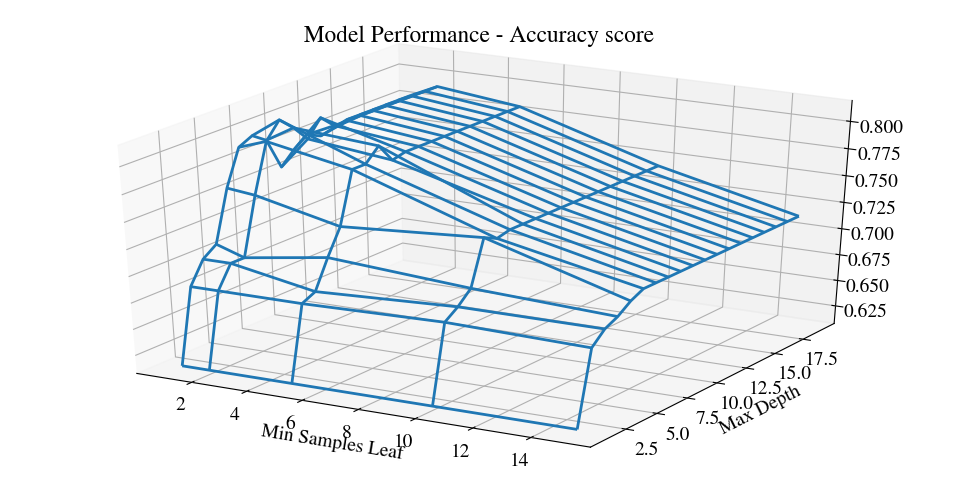

In [55]:
xs, ys = np.meshgrid(min_samples, depths)

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xs, ys,  GS_scores[:,0].reshape(19,5))
plt.title('Model Performance - Accuracy score')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Max Depth')
plt.show()

### SK Learn's cross-val-score
* Get the score for one hyperparameter choice across k-folds of Cross-Validation
* feed it a dict of hyperparameter values - you can search over several hyperparameters
* Estimator: the SK Learn classifier
* cv: default 3-fold, or number of folds, or CV generator (a train/test split iterator)
* scoring: a string indicating the scorer - e.g 'accuracy'

In [56]:
from sklearn.model_selection import cross_val_score

# run it once, to see what scores are yields in each run
scores = cross_val_score(dt_clf, X_train.values, y_train, cv=10, scoring='accuracy')
print (scores)

[0.85714286 0.85714286 0.8        0.82857143 0.71428571 0.72727273
 0.75757576 0.81818182 0.6969697  0.72727273]


#### You need to create a For loop and then save the means and std errors of the scores

In [57]:
acc_scores = np.zeros((len(depths),2))
i =0
for d in depths:
    dt_clf=DecisionTreeClassifier(criterion='gini', max_depth=d, min_samples_leaf=2, random_state=37)
    scores = cross_val_score(dt_clf, X_train.values, y_train, cv=10, scoring='accuracy')
    acc_scores[i, 0] = np.mean(scores)
    acc_scores[i, 1] = np.std(scores)
    i +=1    

print (acc_scores)

[[0.61160173 0.04546765]
 [0.68329004 0.07147636]
 [0.70294372 0.07658443]
 [0.70190476 0.0711476 ]
 [0.75575758 0.07815017]
 [0.79948052 0.06861296]
 [0.81445887 0.06837092]
 [0.8021645  0.07580407]
 [0.78787879 0.07540325]
 [0.80251082 0.07931932]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]
 [0.79090909 0.06816031]]


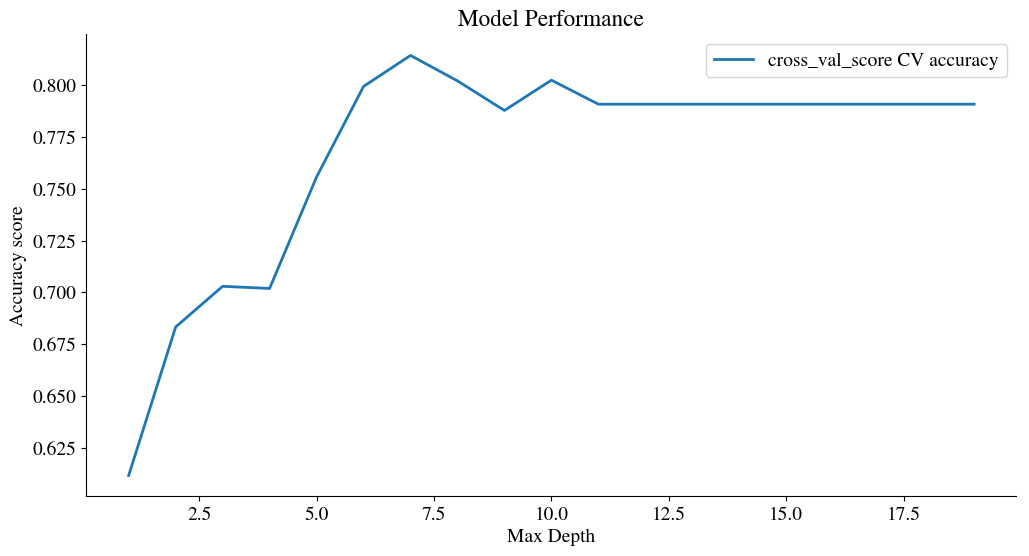

In [58]:
plt.plot(depths, acc_scores[:,0], lw=2, label = 'cross_val_score CV accuracy')
plt.legend(loc=0)
plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Max Depth')
remove_border()
plt.show()

## Alternative perfomance metrics: 
* F1 score
* Precision-Recall
* ROC curves and Area Under the Curve (AUC)

In [59]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [60]:
def print_stats(clf, x_train, x_test, y_train, y_test):

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)

    print("Number of mislabeled points out of a total %d training points : %d"
          % (x_train.shape[0],(y_train != y_pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the training set: ", clf.score(x_train, y_train)))
    
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'accuracy' , n_jobs = 1)
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'f1' , n_jobs = 1)
    report = precision_recall_fscore_support(y_train, y_pred, average='binary')
    acc_score = accuracy_score(y_train, y_pred)
    cm = confusion_matrix(y_pred, y_train)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f" % 
          (report[0], report[1], report[2], acc_score))
    print("\n10-fold CV mean accuracy = %0.3f, mean F1 = %0.3f" % 
          (scores1.mean(), scores2.mean()))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the training set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm, targets)

    pred = clf.predict(x_test)
    y_score = clf.predict_proba(x_test)[:,1]

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)))
    report = precision_recall_fscore_support(y_test, pred, average='binary')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print("*********** AUC for ROC = %0.3f *********************\n" % metrics.roc_auc_score(y_test, y_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm, targets)

Number of mislabeled points out of a total 340 training points : 16
('The hit rate on the training set: ', 0.9529411764705882)

precision = 0.970, recall = 0.937, F1 = 0.953, accuracy = 0.953

10-fold CV mean accuracy = 0.814, mean F1 = 0.811
          0         1
0  0.935673  0.065089
1  0.029240  0.970414 

The confusion matrix on the training set: 
      0    1
0  160   11
1    5  164


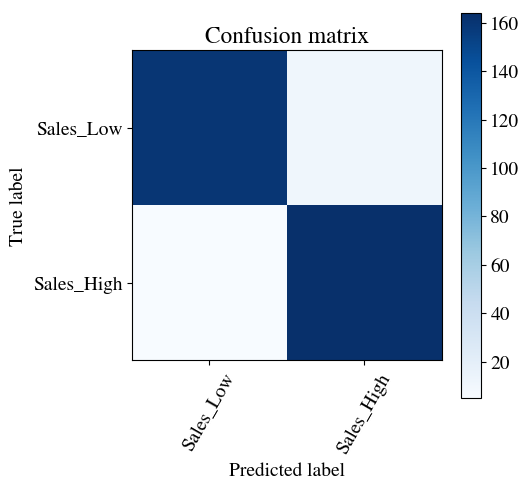

Number of mislabeled points out of a total 60 testing points : 12
('The hit rate on the testing set: ', 0.8)

precision = 0.731, recall = 0.792, F1 = 0.760, accuracy = 0.800

*********** AUC for ROC = 0.862 *********************

          0         1
0  0.852941  0.192308
1  0.205882  0.730769 

The confusion matrix on the testing set: 
     0   1
0  29   5
1   7  19


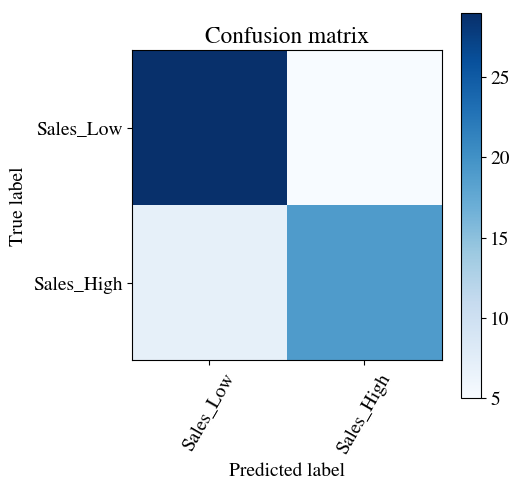

In [61]:
dt_clf=DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=2, random_state=37)
print_stats(dt_clf, X_train.values, X_test.values, y_train, y_test)


<a id='ROC-curves'></a>

--------

[Back to top](#top)


# ROC Curve plot and AUC 

![From the tutorial](ROC_from_tutorial.png)

Image taken from the [ROC curve tutorial](https://www.youtube.com/watch?v=21Igj5Pr6u4)

In [62]:
dt_clf=DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=2, random_state=37)
dt_probas_ = dt_clf.fit(X_train.values, y_train).predict_proba(X_test.values)
dt_probas_.shape

(60, 2)

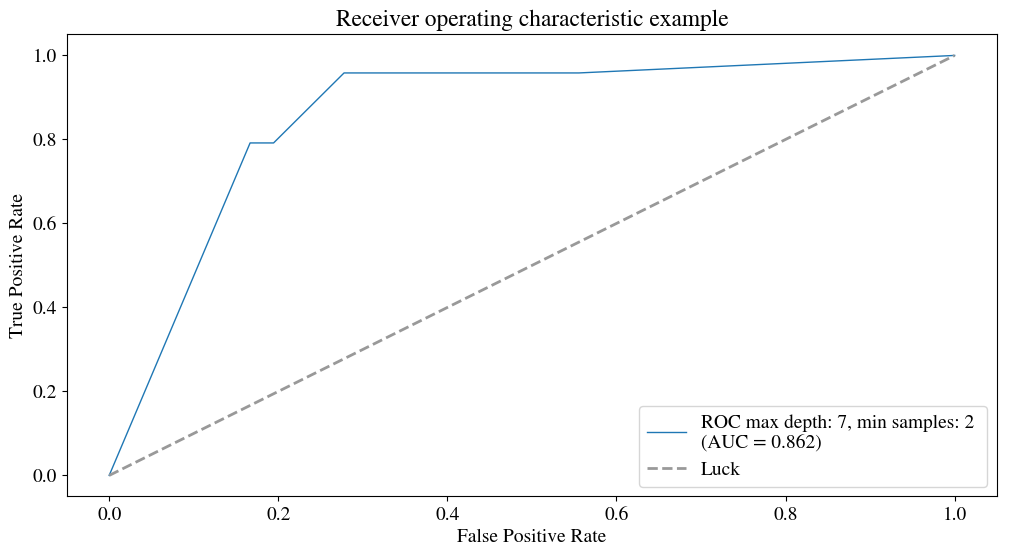

In [63]:
# Compute ROC curve and Area Under the Curve
fpr, tpr, thresholds = roc_curve(y_test, dt_probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC max depth: %d, min samples: %d \n(AUC = %0.3f)' % (dt_clf.max_depth, dt_clf.min_samples_leaf, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### [Deconstructing ROC Curve example from Scikit Learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)

In [64]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
print(fpr) #array([ 0. ,  0.5,  0.5,  1. ])
print(tpr) #array([ 0.5,  0.5,  1. ,  1. ])
thresholds #array([ 0.8 ,  0.4 ,  0.35,  0.1 ])

[0.  0.5 0.5 1. ]
[0.5 0.5 1.  1. ]


array([0.8 , 0.4 , 0.35, 0.1 ])

**True Positive (TP)** - All tuples correctly labeled by the classifier. <br \>
**True Negatives (TN)** - These are negative tuples correctly labeled by the classifier. <br \>
**False Positives (FP)** - These are negative tuples incorrectly labeled as positive by the classifier. <br \>
**False Negatives (FN)** - These are the positive tuples that were incorrectly labeled as negative by the classifier. <br \>
**TPR=TP/P** - Proportion of positive tuples that are correctly labeled by the model. Sensitivity - True  Positives/(Actual positive tuples) <br \>
**FPR=FP/N** - Proportion of negative tuples that are mislabeled as positive. 

Given: y = [1,1,2,2]  scores = [0.1, 0.4, 0.35, 0.8]  (scores are probabilities predicted by the classifier)

Consider: 
Class - 1 = 'N' (Negative) and 2 = 'P' (Positive)  So,  y = ['N','N','P','P'] 

Total P = 2 and N = 2

Prob. - Sorted scores to be considered as threshold

(1) If threshold is 0.8, any tuple >= 0.8 will be classified as positive. Based on y = ['N','N','P','P'] and scores = [0.1, 0.4, 0.35, 0.8], there is 1 tuple that is TP.  There is 1 FN - a positive tuple, incorrectly labeled as negative by classifier. TN =2 and FP = 0

(2) If threshold is 0.4, any tuple >=0.4 will be classified as positive. Based on  y = ['N','N','P','P'] and scores = [0.1, 0.4, 0.35, 0.8], there is 1 tuple that is TP. There is 1 FN - a positive tuple, incorrectly labeled as negative by classifier. There is 1 TN and 1 FP. 

(3) If threshold is 0.35, any tuple >= 0.35 will be classified as positive. Based on  y = ['N','N','P','P'] and scores = [0.1, 0.4, 0.35, 0.8], there are 2 tuples that are TP. There is 0 FN. There is 1 TN and 1 FP.

(4) If threshold is 0.1, any tuple >= 0.1 will be classified as positive.  Based on  y = ['N','N','P','P'] and scores = [0.1, 0.4, 0.35, 0.8],  there are 2 tuples that are TP. There is 0 FN. There is 0 TN and 2 FP.

**Remember:** TP + FN = P and FP + TN = N

|#|Class|Prob.|TP|FP|TN|FN|TPR=TP/P|FPR=FP/N|
|--|-------------------------------|
|1|N |0.8| 1 | 0 | 2 | 1 | 0.5 (1/2)|0 (0/2)
|2|N |0.4| 1 | 1 | 1 | 1 | 0.5 (1/2)|0.5 (1/2)
|3|P |0.35| 2 | 1| 1 | 0 | 1 (2/2)| 0.5 (1/2)
|4|P |0.1| 2 | 2| 0 | 0 | 1 (2/2)| 1 (2/2)

Columns TPR and FPR are same as the scikit learn example. TPR and FPR are plotted on ROC Curve.

<a id='lda'></a>

--------

[Back to top](#top)


# [Linear Discriminant Analysis](http://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)

### Principal Component Analysis vs. Linear Discriminant Analysis

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are commonly used linear transformation techniques in machine learning. PCA can be described as an “unsupervised” algorithm, since it “ignores” class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is “supervised” and computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes.


Discriminant analysis is a composite procedure with two inherent stages - dimensionality reduction (supervised) and classification stage. At dimensionality reduction we extract discriminant functions which replace the original explanatory variables. Then we classify (typically by Bayes' approach) observations to the classes using those functions.

http://sebastianraschka.com/Articles/2014_python_lda.html#principal-component-analysis-vs-linear-discriminant-analysis

### LDA (Supervised Classification)

In [65]:
print(df.Spam_YN.value_counts()/df.shape[0])

X = df.iloc[:,0:57]
y = df.Spam_YN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=10) 
print (X.shape, X_train.shape, X_test.shape)
X.describe()

0    0.605955
1    0.394045
Name: Spam_YN, dtype: float64
(4601, 57) (2990, 57) (1611, 57)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


(2990, 57) (2990,) (1611, 57) (1611,)
Number of mislabeled points out of a total 2990 training points : 340
('The hit rate on the training set: ', 0.8862876254180602)

precision = 0.920, recall = 0.776, F1 = 0.842, accuracy = 0.886

10-fold CV mean accuracy = 0.883, mean F1 = 0.836
          0         1
0  0.870020  0.265784
1  0.039343  0.919552 

The confusion matrix on the training set: 
       0    1
0  1747  261
1    79  903


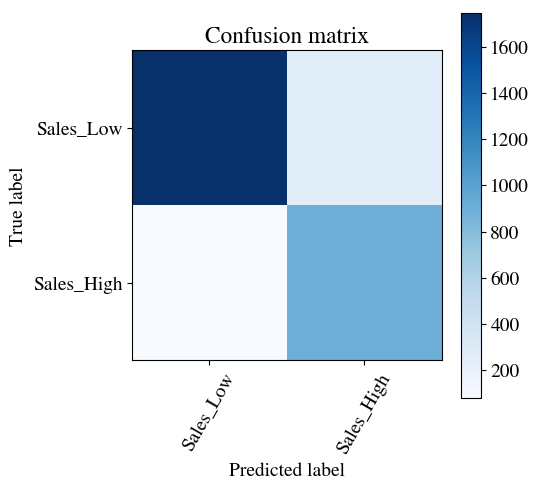

Number of mislabeled points out of a total 1611 testing points : 195
('The hit rate on the testing set: ', 0.8789571694599627)

precision = 0.916, recall = 0.770, F1 = 0.837, accuracy = 0.879

*********** AUC for ROC = 0.955 *********************

          0         1
0  0.860094  0.272894
1  0.043192  0.915751 

The confusion matrix on the testing set: 
      0    1
0  916  149
1   46  500


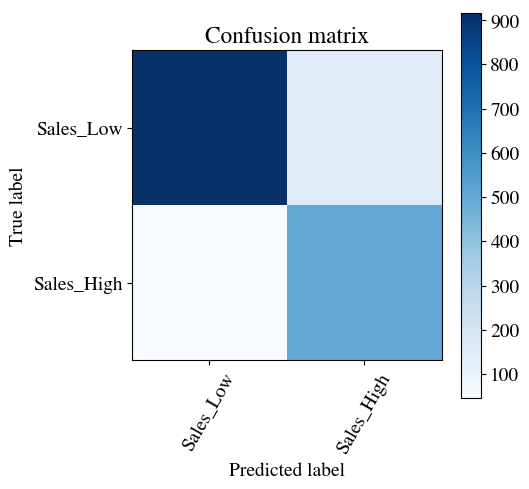

In [66]:
print (X_train.shape, y_train.shape, X_test.shape,y_test.shape)

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred_lda = lda_clf.predict(X_test)
lda_probas_ = lda_clf.predict_proba(X_test)
score = metrics.accuracy_score(y_test, y_pred_lda)

print_stats(lda_clf, X_train.values, X_test.values, y_train, y_test)

Number of mislabeled points out of a total 2990 training points : 505
('The hit rate on the training set: ', 0.8311036789297659)

precision = 0.795, recall = 0.763, F1 = 0.779, accuracy = 0.831

10-fold CV mean accuracy = 0.784, mean F1 = 0.714
          0         1
0  0.852643  0.247090
1  0.122264  0.794987 

The confusion matrix on the training set: 
       0    1
0  1597  276
1   229  888


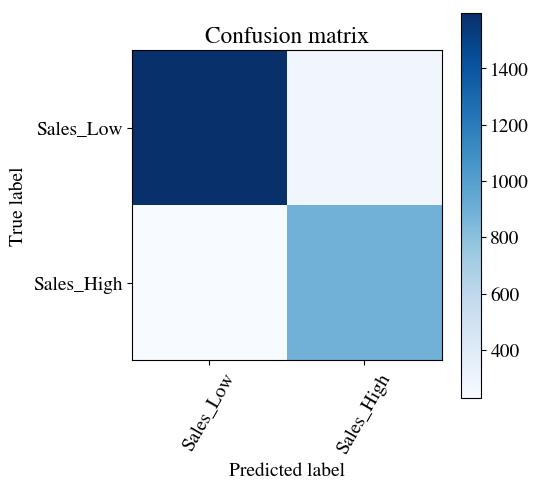

Number of mislabeled points out of a total 1611 testing points : 323
('The hit rate on the testing set: ', 0.7995034140285537)

precision = 0.761, recall = 0.732, F1 = 0.746, accuracy = 0.800

*********** AUC for ROC = 0.866 *********************

          0         1
0  0.823708  0.278846
1  0.150963  0.761218 

The confusion matrix on the testing set: 
      0    1
0  813  174
1  149  475


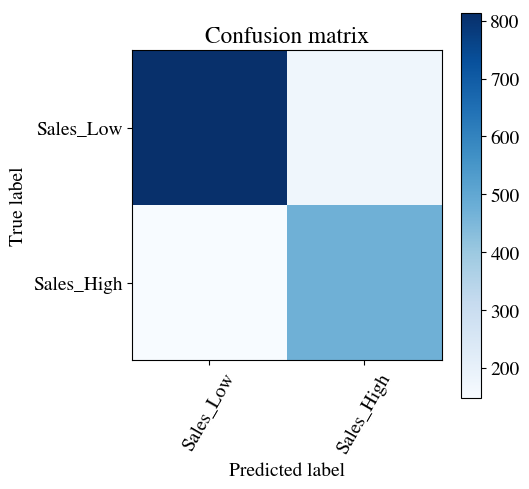

In [67]:
knn_clf = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
knn_probas_ = knn_clf.predict_proba(X_test)
print_stats(knn_clf, X_train.values, X_test.values, y_train, y_test)

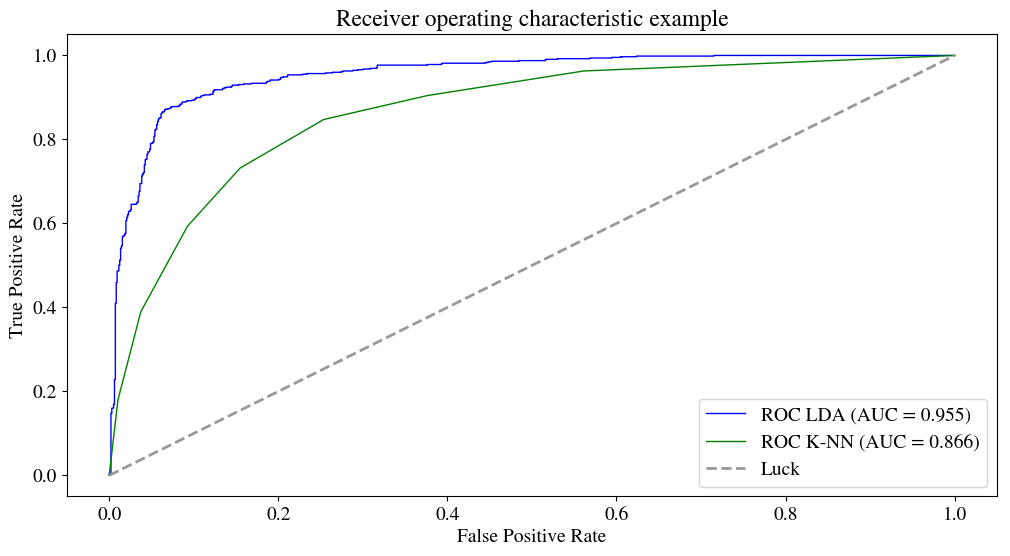

In [68]:
# Compute ROC curve and Area Under the Curve
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, lda_probas_[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)
plt.plot(fpr_lda, tpr_lda, lw=1, color='blue', label='ROC LDA (AUC = %0.3f)' % (roc_auc_lda))

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_probas_[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=1, color='green', label='ROC K-NN (AUC = %0.3f)' % (roc_auc_knn))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()